In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv('sortedGameLogs.csv')
df=df.drop(columns='Unnamed: 0')
df[['PLAYER_ID','GAME_ID','PTS', 'REB', 'AST', 'MIN', 'FGA', 'FG3A', 'FTA', 'STL','BLK','TOV']].head(),df[['PLAYER_ID','GAME_ID','PTS', 'REB', 'AST', 'MIN', 'FGA', 'FG3A', 'FTA', 'STL','BLK', 'TOV']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26401 entries, 0 to 26400
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PLAYER_ID  26401 non-null  int64  
 1   GAME_ID    26401 non-null  int64  
 2   PTS        26401 non-null  int64  
 3   REB        26401 non-null  int64  
 4   AST        26401 non-null  int64  
 5   MIN        26401 non-null  float64
 6   FGA        26401 non-null  int64  
 7   FG3A       26401 non-null  int64  
 8   FTA        26401 non-null  int64  
 9   STL        26401 non-null  int64  
 10  BLK        26401 non-null  int64  
 11  TOV        26401 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 2.4 MB


(   PLAYER_ID   GAME_ID  PTS  REB  AST        MIN  FGA  FG3A  FTA  STL  BLK  \
 0       2544  22300015   32   11    6  36.383333   17     4   11    1    1   
 1       2544  22300026   16    9    6  22.650000   11     6    2    1    0   
 2       2544  22300036   35    5    9  34.533333   22     9    6    2    0   
 3       2544  22300042   17    7    9  24.016667   10     5    2    0    0   
 4       2544  22300061   21    8    5  29.010000   16     4    1    1    0   
 
    TOV  
 0    4  
 1    4  
 2    3  
 3    2  
 4    0  ,
 None)

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
def prepare_multi_player_sequences(df, features, sequence_length, min_games_per_player=10):
    """
    Prepare time series sequences for multiple players
    
    Args:
    - df: DataFrame with player game-level data
    - features: List of feature columns to use
    - sequence_length: Number of previous games to use for prediction
    - min_games_per_player: Minimum games a player must have to be included
    
    Returns:
    - X: Input sequences
    - y: Target sequences
    - scaler: Feature scaler
    """
    # Sort data chronologically for each player
    df_sorted = df.sort_values(['PLAYER_ID', 'GAME_ID'])
    
    # Filter players with sufficient game history
    player_game_counts = df_sorted['PLAYER_ID'].value_counts()
    valid_players = player_game_counts[player_game_counts >= min_games_per_player].index
    
    df_filtered = df_sorted[df_sorted['PLAYER_ID'].isin(valid_players)]
    
    # Standardize features across ALL players
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_filtered[features])
    
    # Prepare sequences
    sequences_X, sequences_y = [], []
    
    for player_id in valid_players:
        player_data = scaled_features[df_filtered['PLAYER_ID'] == player_id]
        
        # Create sequences for this player
        for i in range(len(player_data) - sequence_length):
            sequences_X.append(player_data[i:i+sequence_length])
            sequences_y.append(player_data[i+sequence_length])
    
    return (np.array(sequences_X), 
            np.array(sequences_y), 
            scaler)

def create_lstm_model(sequence_length, num_features):
    """
    Create LSTM model for time series prediction
    
    Args:
    - sequence_length: Number of time steps in input sequence
    - num_features: Number of features to predict
    
    Returns:
    - Compiled Keras model
    """
    model = Sequential([
        LSTM(64, 
             input_shape=(sequence_length, num_features), 
             return_sequences=True,
             activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_features)
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

def train_time_series_model(X, y, test_size=0.2, epochs=100):
    """
    Train and evaluate time series model
    
    Args:
    - X: Input sequences
    - y: Target sequences
    - test_size: Proportion of data for validation
    - epochs: Maximum training epochs
    
    Returns:
    - Trained model
    - Training history
    - X_test
    - y_test
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    
    # Model and callbacks
    model = create_lstm_model(X.shape[1], X.shape[2])
    
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=15, 
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        patience=5, 
        min_lr=0.00001
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    return model, history, X_test, y_test

Epoch 1/100


/Users/jamesstevens/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


605/605 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0359 - mae: 0.7697 - val_loss: 0.4302 - val_mae: 0.4970 - learning_rate: 0.0010
Epoch 2/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7277 - mae: 0.6468 - val_loss: 0.4151 - val_mae: 0.4780 - learning_rate: 0.0010
Epoch 3/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7019 - mae: 0.6341 - val_loss: 0.4205 - val_mae: 0.4899 - learning_rate: 0.0010
Epoch 4/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6928 - mae: 0.6286 - val_loss: 0.4087 - val_mae: 0.4748 - learning_rate: 0.0010
Epoch 5/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6898 - mae: 0.6288 - val_loss: 0.4148 - val_mae: 0.4780 - learning_rate: 0.0010
Epoch 6/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6785 - mae: 0.6218 - val_loss: 0.4240 - val_mae: 0.5011 - learning_rate: 0.0010
Epoch 7/100
605/605 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6796 - mae: 0.6240 - val_loss: 0.4329 - val_mae: 0.5117 - learning_rate: 0.0010
Epoch 8/100

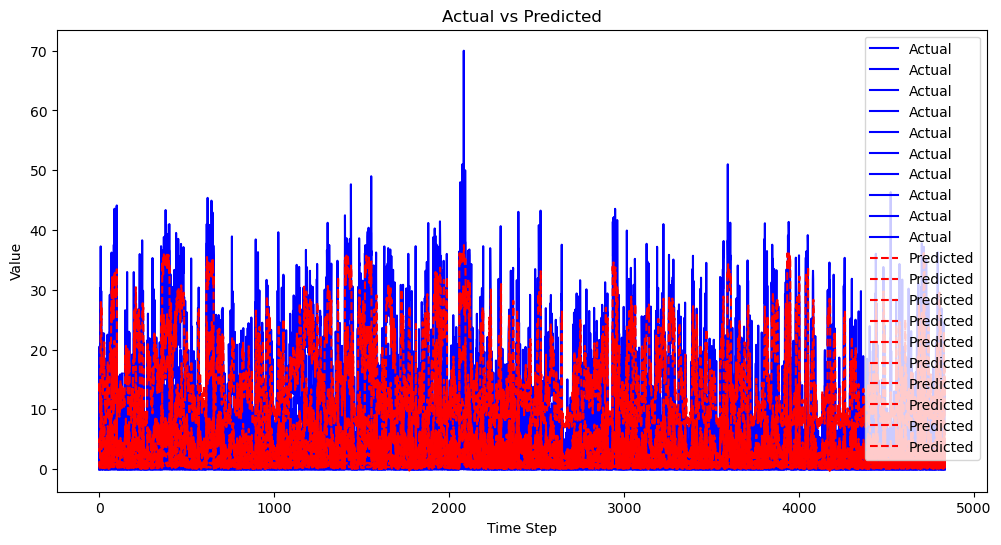

In [7]:
features = ['PTS', 'REB', 'AST', 'MIN', 'FGA', 'FG3A', 'FTA','STL','BLK', 'TOV']
sequence_length = 4

# Prepare sequences
X, y, scaler = prepare_multi_player_sequences(
    df, 
    features=features, 
    sequence_length=sequence_length,
    min_games_per_player=4  # Adjust based on your dataset
)

# Train model and get test sets
model, history, X_test, y_test = train_time_series_model(X, y)

# Make predictions
y_pred = model.predict(X_test)

# Rescale predictions and test values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Calculate MAE and RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Visualization of predictions vs actual values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
# Plot actual vs predicted values
plt.plot(y_test_rescaled, label='Actual', color='blue')
plt.plot(y_pred_rescaled, label='Predicted', color='red', linestyle='dashed')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

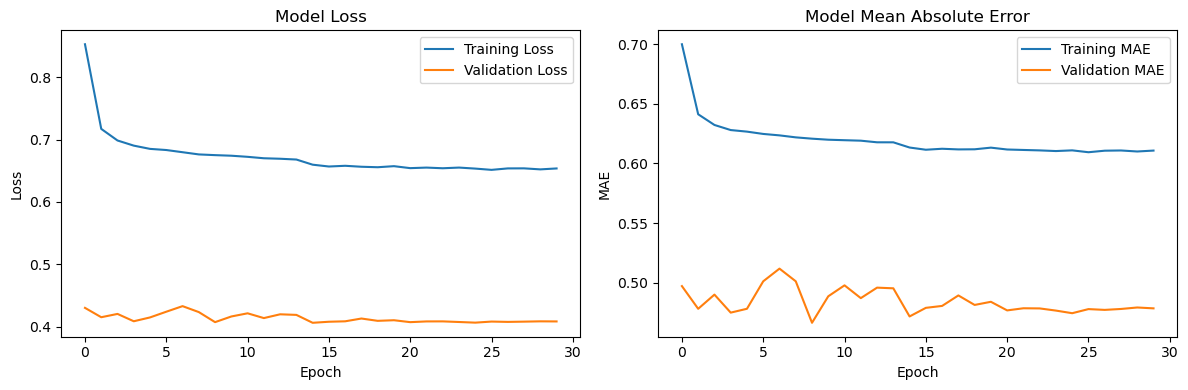

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

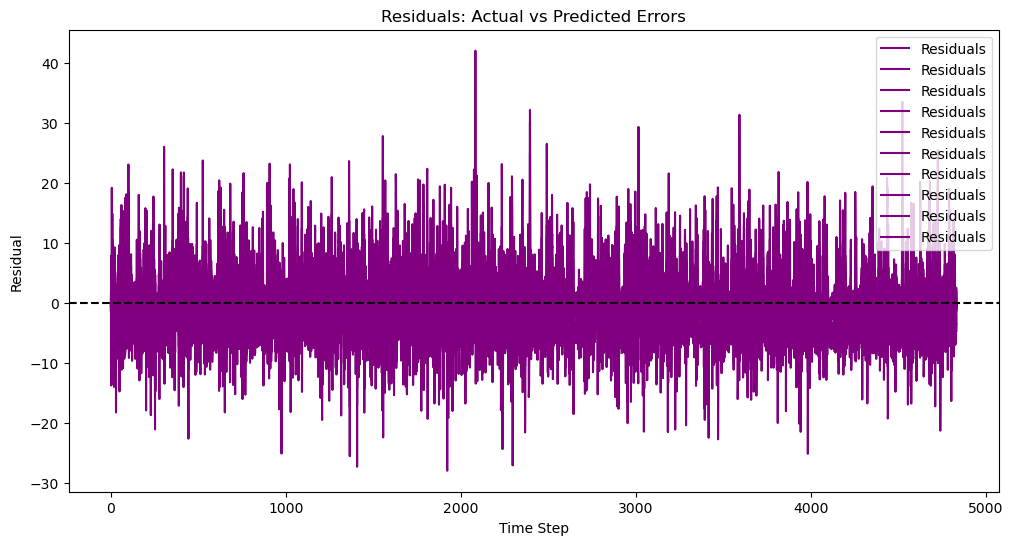

In [11]:
# Residuals: difference between actual and predicted values
residuals = y_test_rescaled - y_pred_rescaled

plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals', color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Residual')
plt.title('Residuals: Actual vs Predicted Errors')
plt.legend()
plt.show()

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step


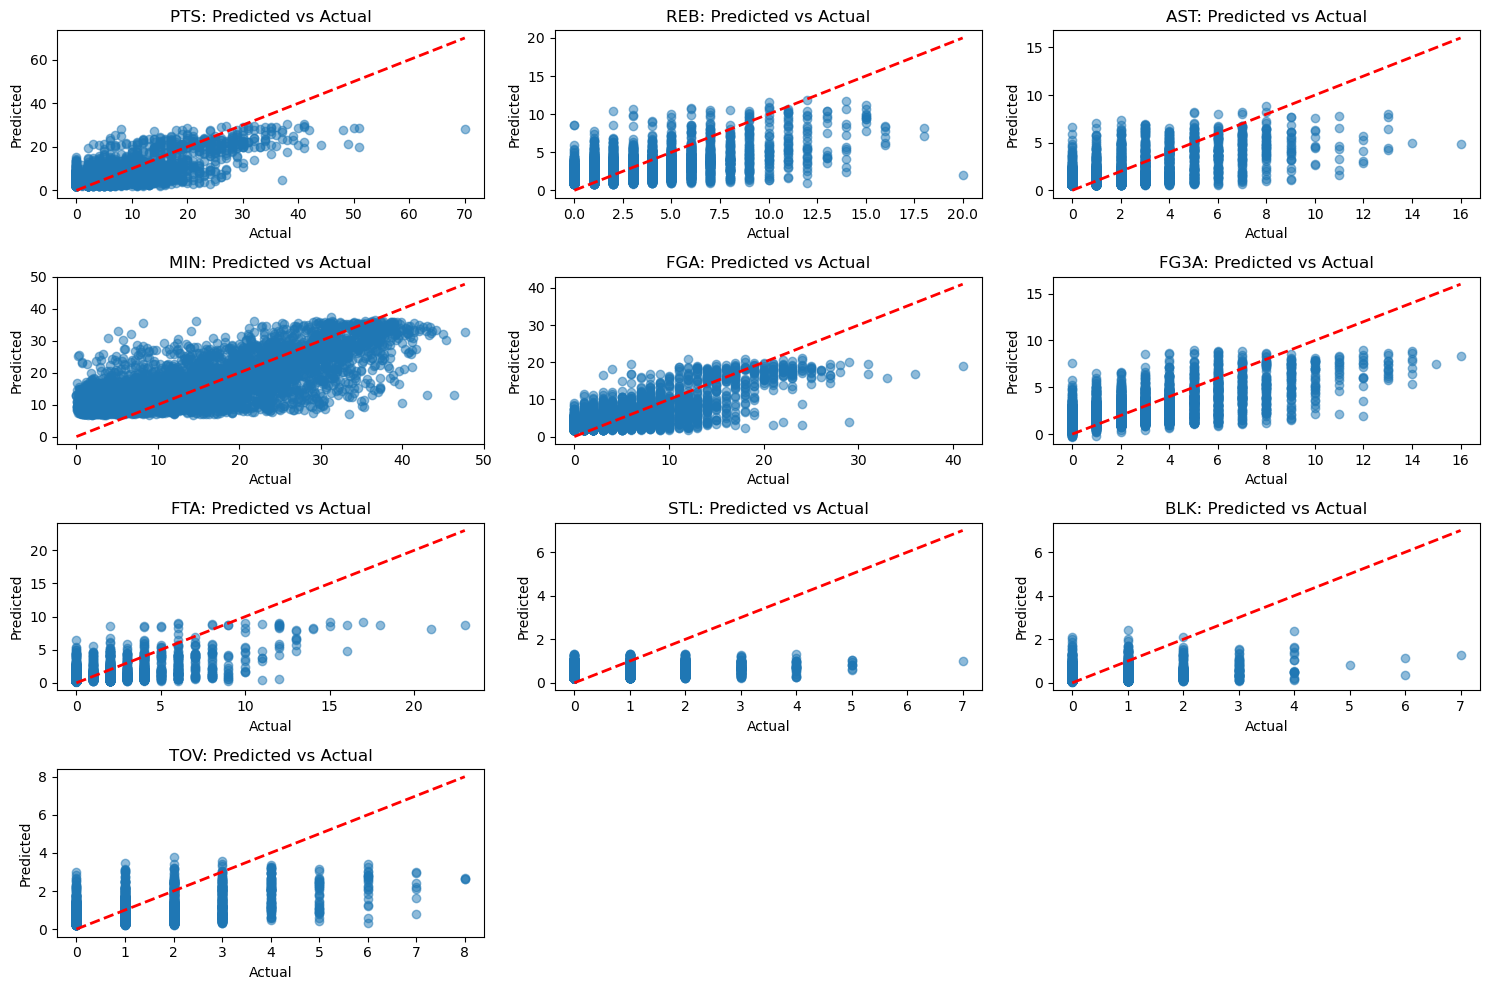

Detailed Feature-wise Metrics:

PTS:
  MAE: 3.8041
  MSE: 24.7853
  RMSE: 4.9785
  R2: 0.5102

REB:
  MAE: 1.6708
  MSE: 4.9498
  RMSE: 2.2248
  R2: 0.3676

AST:
  MAE: 1.1102
  MSE: 2.3020
  RMSE: 1.5172
  R2: 0.4128

MIN:
  MAE: 5.8427
  MSE: 52.2618
  RMSE: 7.2292
  R2: 0.5497

FGA:
  MAE: 2.5068
  MSE: 10.7558
  RMSE: 3.2796
  R2: 0.5814

FG3A:
  MAE: 1.3365
  MSE: 3.1018
  RMSE: 1.7612
  R2: 0.5085

FTA:
  MAE: 1.1532
  MSE: 2.7173
  RMSE: 1.6484
  R2: 0.3606

STL:
  MAE: 0.5746
  MSE: 0.5730
  RMSE: 0.7570
  R2: 0.0919

BLK:
  MAE: 0.4181
  MSE: 0.3768
  RMSE: 0.6138
  R2: 0.0985

TOV:
  MAE: 0.6891
  MSE: 0.8540
  RMSE: 0.9241
  R2: 0.3189


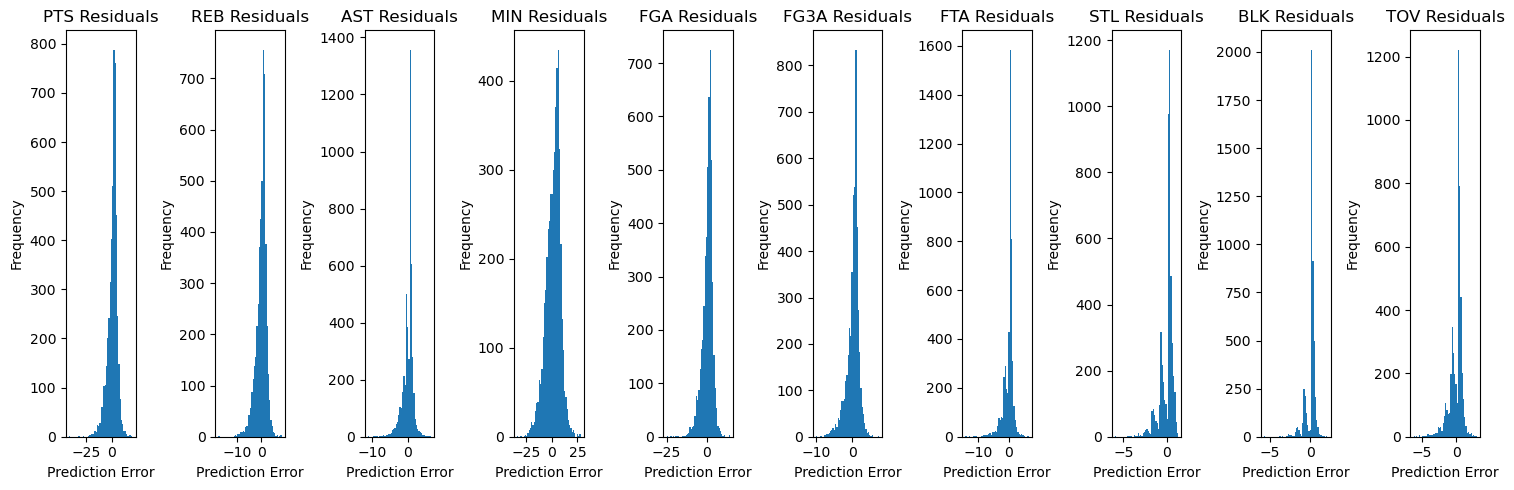

In [13]:
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model_predictions(model, X_test, y_test, scaler, features):
    """
    Comprehensive model evaluation function
    
    Args:
    - model: Trained LSTM model
    - X_test: Test input sequences
    - y_test: Test target sequences
    - scaler: Feature scaler used during preprocessing
    - features: List of feature names
    
    Returns:
    - Detailed evaluation metrics and visualizations
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test)
    
    # Compute evaluation metrics for each feature
    metrics = {}
    for i, feature in enumerate(features):
        mae = mean_absolute_error(y_test_original[:, i], y_pred_original[:, i])
        mse = mean_squared_error(y_test_original[:, i], y_pred_original[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test_original[:, i], y_pred_original[:, i])
        
        metrics[feature] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        }
    
    # Visualization: Predicted vs Actual for each feature
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(features):
        plt.subplot(4, 3, i+1)
        plt.scatter(y_test_original[:, i], y_pred_original[:, i], alpha=0.5)
        plt.plot([y_test_original[:, i].min(), y_test_original[:, i].max()], 
                 [y_test_original[:, i].min(), y_test_original[:, i].max()], 
                 'r--', lw=2)
        plt.title(f'{feature}: Predicted vs Actual')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    print("Detailed Feature-wise Metrics:")
    for feature, metric in metrics.items():
        print(f"\n{feature}:")
        for metric_name, value in metric.items():
            print(f"  {metric_name}: {value:.4f}")
    
    # Residual plot for overall performance
    residuals = y_pred_original - y_test_original
    plt.figure(figsize=(15, 5))
    for i, feature in enumerate(features):
        plt.subplot(1, len(features), i+1)
        plt.hist(residuals[:, i], bins=50)
        plt.title(f'{feature} Residuals')
        plt.xlabel('Prediction Error')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    return metrics, y_pred_original, y_test_original

# Evaluate the model
evaluation_metrics, predictions, actual = evaluate_model_predictions(
    model, X_test, y_test, scaler, features
)

In [16]:
def evaluate_by_player_segment(model, X_test, y_test, scaler, features, df):
    """
    Evaluate model performance across different player segments
    """
    y_pred = model.predict(X_test)
    y_pred_original = scaler.inverse_transform(y_pred)
    y_test_original = scaler.inverse_transform(y_test)
    
    # Ensure temp_df aligns with X_test and y_test
    temp_df = df.iloc[len(df) - len(y_test):].copy()
    
    # Segment by total minutes played
    temp_df['avg_minutes'] = temp_df.groupby('PLAYER_ID')['MIN'].transform('mean')
    
    # Create segments
    temp_df['minute_segment'] = pd.cut(
        temp_df['avg_minutes'], 
        bins=3, 
        labels=['Low', 'Medium', 'High']
    )
    
    print("Performance by Player Minute Segments:")
    for segment in ['Low', 'Medium', 'High']:
        print(f"\n{segment} Minutes Players:")
        
        # Find indices for this segment
        segment_indices = temp_df['minute_segment'] == segment
        
        # Filter predictions and actual values for this segment
        segment_indices = segment_indices.values  # Convert to numpy array to match dimensions
        segment_pred = y_pred_original[segment_indices]
        segment_actual = y_test_original[segment_indices]
        
        if len(segment_pred) > 0:
            for i, feature in enumerate(features):
                mae = mean_absolute_error(segment_actual[:, i], segment_pred[:, i])
                print(f"  {feature} MAE: {mae:.4f}")
        else:
            print(f"  {feature}: No data in this segment")


def prediction_intervals(y_pred, y_test, features, confidence=0.95):
    """
    Calculate prediction intervals
    """
    print("\nPrediction Intervals:")
    errors = np.abs(y_pred - y_test)
    
    for i, feature in enumerate(features):
        # Adjust confidence to percentiles
        lower_percentile = (1 - confidence) * 50
        upper_percentile = 100 - lower_percentile
        
        # Calculate intervals
        lower = np.percentile(errors[:, i], lower_percentile)
        median = np.percentile(errors[:, i], 50)
        upper = np.percentile(errors[:, i], upper_percentile)
        
        print(f"\n{feature}:")
        print(f"  {confidence*100}% Prediction Interval:")
        print(f"    Lower bound: {lower:.4f}")
        print(f"    Median error: {median:.4f}")
        print(f"    Upper bound: {upper:.4f}")

In [19]:
print("\n--- Player Segment Analysis ---")
evaluate_by_player_segment(model, X_test, y_test, scaler, features, df)

print("\n--- Prediction Intervals ---")
prediction_intervals(
    scaler.inverse_transform(model.predict(X_test)), 
    scaler.inverse_transform(y_test), 
    features
)


--- Player Segment Analysis ---
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
Performance by Player Minute Segments:

Low Minutes Players:
  PTS MAE: 3.6351
  REB MAE: 1.4728
  AST MAE: 1.1421
  MIN MAE: 5.8803
  FGA MAE: 2.3813
  FG3A MAE: 1.3432
  FTA MAE: 1.0621
  STL MAE: 0.5693
  BLK MAE: 0.3742
  TOV MAE: 0.6643

Medium Minutes Players:
  PTS MAE: 3.8224
  REB MAE: 1.7867
  AST MAE: 1.1054
  MIN MAE: 5.9741
  FGA MAE: 2.5645
  FG3A MAE: 1.3200
  FTA MAE: 1.1963
  STL MAE: 0.5699
  BLK MAE: 0.4544
  TOV MAE: 0.6970

High Minutes Players:
  PTS MAE: 3.9459
  REB MAE: 1.6862
  AST MAE: 1.0856
  MIN MAE: 5.5950
  FGA MAE: 2.5415
  FG3A MAE: 1.3562
  FTA MAE: 1.1765
  STL MAE: 0.5876
  BLK MAE: 0.4044
  TOV MAE: 0.7016

--- Prediction Intervals ---
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step

Prediction Intervals:

PTS:
  95.0% Prediction Interval:
    Lower bound: 0.1894
    Median error: 3.0302
    Upper bound: 12.2295

REB:
  95.0% Prediction Interval:
    Lower bound: 0.0620
    Medi